In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import re

### 👾 Load Data

In [25]:
file_path = "data_from_wandb.csv"
df = pd.read_csv(file_path)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         104 non-null    object 
 1   State                        104 non-null    object 
 2   Notes                        104 non-null    object 
 3   User                         0 non-null      float64
 4   Tags                         104 non-null    object 
 5   Created                      104 non-null    object 
 6   Runtime                      104 non-null    int64  
 7   Sweep                        0 non-null      float64
 8   Accuracy                     91 non-null     float64
 9   Average Inference Time (ms)  91 non-null     float64
 10  Dataset Name                 91 non-null     object 
 11  GPU Memory Usage (MB)        91 non-null     float64
 12  Model Size (MB)              91 non-null     float64
dtypes: float64(6), int64

In [27]:
df = df[df['State'] == 'finished']

In [28]:
df[['col1', 'col2', 'col3']] = df['Tags'].str.split(', ', expand=True)

# device 및 dataset 후보 목록
device_candidates = ['Orin', 'A100']
dataset_candidates = ['winogrande', 'social_i_qa', 'allenai/ai2_arc', 'openbookqa', 'piqa', 'boolq']

# device, dataset, model 정리
def classify_columns(row):
    device = None
    dataset = None
    model = None

    for col in ['col1', 'col2', 'col3']:
        if row[col] in device_candidates:
            device = row[col]
        elif row[col] in dataset_candidates:
            dataset = row[col]
        else:
            model = row[col]

    return pd.Series([device, model, dataset])

df[['Device', 'Model', 'Dataset']] = df.apply(classify_columns, axis=1)

df['Model'] = df['Model'].str.split('/').str[-1]

df = df.drop(['Tags', 'col1', 'col2', 'col3'], axis=1)

In [29]:
df['GPU Memory Usage (GB)'] = df['GPU Memory Usage (MB)'] / 1024

In [30]:
dataset_mapping = {
    'winogrande': 'WinoGrande',
    'social_i_qa': 'SIQA',
    'allenai/ai2_arc': 'ARC-e',
    'openbookqa': 'OBQA',
    'piqa': 'PIQA',
    'boolq': 'BoolQ'
}
df['Dataset'] = df['Dataset'].replace(dataset_mapping)

In [31]:
def extract_parameters(model_name):
    match = re.search(r'([\d.]+)([MBT])', model_name, re.IGNORECASE)
    if match:
        value, unit = match.groups()
        unit = unit.upper()
        if unit == 'B':
            return f"{int(float(value) * 1000)}M"
        return f"{value}{unit}"
    return "Unknown"

df['Parameters'] = df['Model'].apply(extract_parameters)

In [32]:
data = df[['Device', 'Model', 'Parameters', 'Dataset', 'State', 'Accuracy', 'Average Inference Time (ms)', 'GPU Memory Usage (GB)', 'Model Size (MB)']]
data = data.sort_values(by='Parameters', ascending=True)

In [33]:
data

,Device,Model,Parameters,Dataset,State,Accuracy,Average Inference Time (ms),GPU Memory Usage (GB),Model Size (MB)
103,Orin,Cerebras-GPT-111M,111M,WinoGrande,finished,49.565904,49.356640,0.486320,423.624023
101,Orin,Cerebras-GPT-111M,111M,ARC-e,finished,26.491228,47.848207,0.518592,423.624023
100,Orin,Cerebras-GPT-111M,111M,SIQA,finished,33.700000,46.560314,0.509212,423.624023
99,Orin,Cerebras-GPT-111M,111M,BoolQ,finished,38.000000,75.053353,0.607112,423.624023
102,Orin,Cerebras-GPT-111M,111M,OBQA,finished,25.000000,42.651917,0.511304,423.624023
...,...,...,...,...,...,...,...,...,...
26,Orin,Cerebras-GPT-590M,590M,BoolQ,finished,37.900000,407.802800,2.551911,2251.857422
2,Orin,Cerebras-GPT-590M,590M,PIQA,finished,49.200000,279.489521,2.546453,2251.857422
25,Orin,LaMini-GPT-774M,774M,WinoGrande,finished,51.065509,241.841742,3.012091,2952.695312
24,Orin,LaMini-GPT-774M,774M,OBQA,finished,31.200000,288.770704,3.024188,2952.695312


### 👾 Data Analysis Result

In [39]:
pip install tabulate

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
df_pivot = df.pivot_table(index=['Model', 'Parameters'], columns='Dataset', values='Accuracy')
df_pivot['Avg.'] = df_pivot.mean(axis=1)

df_pivot.reset_index(inplace=True)

df_pivot.columns.name = None

print(df_pivot.to_markdown(index=False))

| Model             | Parameters   |   ARC-e |   BoolQ |   OBQA |   PIQA |   SIQA |   WinoGrande |    Avg. |
|:------------------|:-------------|--------:|--------:|-------:|-------:|-------:|-------------:|--------:|
| Cerebras-GPT-111M | 111M         | 26.4912 |    38   |   25   |   49.2 |   33.7 |      49.5659 | 36.9929 |
| Cerebras-GPT-256M | 256M         | 26.4912 |    38.1 |   25   |   49.2 |   33.7 |      49.5659 | 37.0095 |
| Cerebras-GPT-590M | 590M         | 26.4912 |    37.9 |   25   |   49.2 |   33.7 |      49.5659 | 36.9762 |
| LaMini-GPT-124M   | 124M         | 24.9123 |    62.4 |   24   |   50.8 |   33.1 |      50.4341 | 40.9411 |
| LaMini-GPT-774M   | 774M         | 32.6316 |   nan   |   31.2 |  nan   |  nan   |      51.0655 | 38.299  |
| LiteLlama-460M-1T | 460M         | 25.614  |    38.1 |   25.2 |   49.3 |   34   |      49.5659 | 36.9633 |
| Qwen1.5-0.5B      | 500M         | 54.7368 |    59.7 |   42   |  nan   |   42.3 |      50.8287 | 49.9131 |
| Qwen2.5-0.5B     

In [46]:
df_pivot = df.pivot_table(index=['Model', 'Parameters'], columns='Dataset', values='Average Inference Time (ms)')
df_pivot['Avg.'] = df_pivot.mean(axis=1)

df_pivot.reset_index(inplace=True)

df_pivot.columns.name = None

print(df_pivot.to_markdown(index=False))

| Model             | Parameters   |    ARC-e |    BoolQ |     OBQA |     PIQA |     SIQA |   WinoGrande |     Avg. |
|:------------------|:-------------|---------:|---------:|---------:|---------:|---------:|-------------:|---------:|
| Cerebras-GPT-111M | 111M         |  47.8482 |  75.0534 |  42.6519 |  67.5944 |  46.5603 |      49.3566 |  54.8441 |
| Cerebras-GPT-256M | 256M         | 118.458  | 197.908  | 104.827  | 118.09   | 125.461  |      76.8072 | 123.592  |
| Cerebras-GPT-590M | 590M         | 251.496  | 407.803  | 227.772  | 279.49   | 252.317  |     195.598  | 269.079  |
| LaMini-GPT-124M   | 124M         |  55.5167 |  91.169  |  50.3607 |  70.0167 |  53.6331 |      51.48   |  62.0294 |
| LaMini-GPT-774M   | 774M         | 331.246  | nan      | 288.771  | nan      | nan      |     241.842  | 287.286  |
| LiteLlama-460M-1T | 460M         | 173.447  | 278.426  | 156.089  | 181.297  | 173.079  |     124.438  | 181.129  |
| Qwen1.5-0.5B      | 500M         | 175.618  | 305.815 

In [55]:
df_pivot = df.pivot_table(index=['Model', 'Parameters'], columns='Dataset', values='Model Size (MB)')
df_pivot['Avg.'] = df_pivot.mean(axis=1)

df_pivot.reset_index(inplace=True)

df_pivot.columns.name = None

print(df_pivot.to_markdown(index=False))

| Model             | Parameters   |    ARC-e |    BoolQ |     OBQA |     PIQA |     SIQA |   WinoGrande |     Avg. |
|:------------------|:-------------|---------:|---------:|---------:|---------:|---------:|-------------:|---------:|
| Cerebras-GPT-111M | 111M         |  423.624 |  423.624 |  423.624 |  423.624 |  423.624 |      423.624 |  423.624 |
| Cerebras-GPT-256M | 256M         |  976.475 |  976.475 |  976.475 |  976.475 |  976.475 |      976.475 |  976.475 |
| Cerebras-GPT-590M | 590M         | 2251.86  | 2251.86  | 2251.86  | 2251.86  | 2251.86  |     2251.86  | 2251.86  |
| LaMini-GPT-124M   | 124M         |  474.703 |  474.703 |  474.703 |  474.703 |  474.703 |      474.703 |  474.703 |
| LaMini-GPT-774M   | 774M         | 2952.7   |  nan     | 2952.7   |  nan     |  nan     |     2952.7   | 2952.7   |
| LiteLlama-460M-1T | 460M         | 1761.19  | 1761.19  | 1761.19  | 1761.19  | 1761.19  |     1761.19  | 1761.19  |
| Qwen1.5-0.5B      | 500M         | 1769.97  | 1769.97 

In [56]:
df_pivot = df.pivot_table(index=['Model', 'Parameters'], columns='Dataset', values='GPU Memory Usage (GB)')
df_pivot['Avg.'] = df_pivot.mean(axis=1)

df_pivot.reset_index(inplace=True)

df_pivot.columns.name = None

print(df_pivot.to_markdown(index=False))

| Model             | Parameters   |    ARC-e |      BoolQ |     OBQA |       PIQA |       SIQA |   WinoGrande |     Avg. |
|:------------------|:-------------|---------:|-----------:|---------:|-----------:|-----------:|-------------:|---------:|
| Cerebras-GPT-111M | 111M         | 0.518592 |   0.607112 | 0.511304 |   0.604109 |   0.509212 |     0.48632  | 0.539441 |
| Cerebras-GPT-256M | 256M         | 1.09269  |   1.21178  | 1.07552  |   1.20522  |   1.07341  |     1.04991  | 1.11809  |
| Cerebras-GPT-590M | 590M         | 2.38433  |   2.55191  | 2.37     |   2.54645  |   2.36661  |     2.33764  | 2.42616  |
| LaMini-GPT-124M   | 124M         | 0.518301 |   0.582409 | 0.511014 |   0.580349 |   0.508922 |     0.499037 | 0.533339 |
| LaMini-GPT-774M   | 774M         | 3.03155  | nan        | 3.02419  | nan        | nan        |     3.01209  | 3.02261  |
| LiteLlama-460M-1T | 460M         | 1.76578  |   1.83748  | 1.75761  |   1.83512  |   1.75526  |     1.74412  | 1.78256  |
| Qwen1.

/var/folders/bj/tl0_3rjs2r309b_7b62d64yh0000gn/T/ipykernel_20887/618486095.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Model', y='Accuracy',  palette = 'Blues')


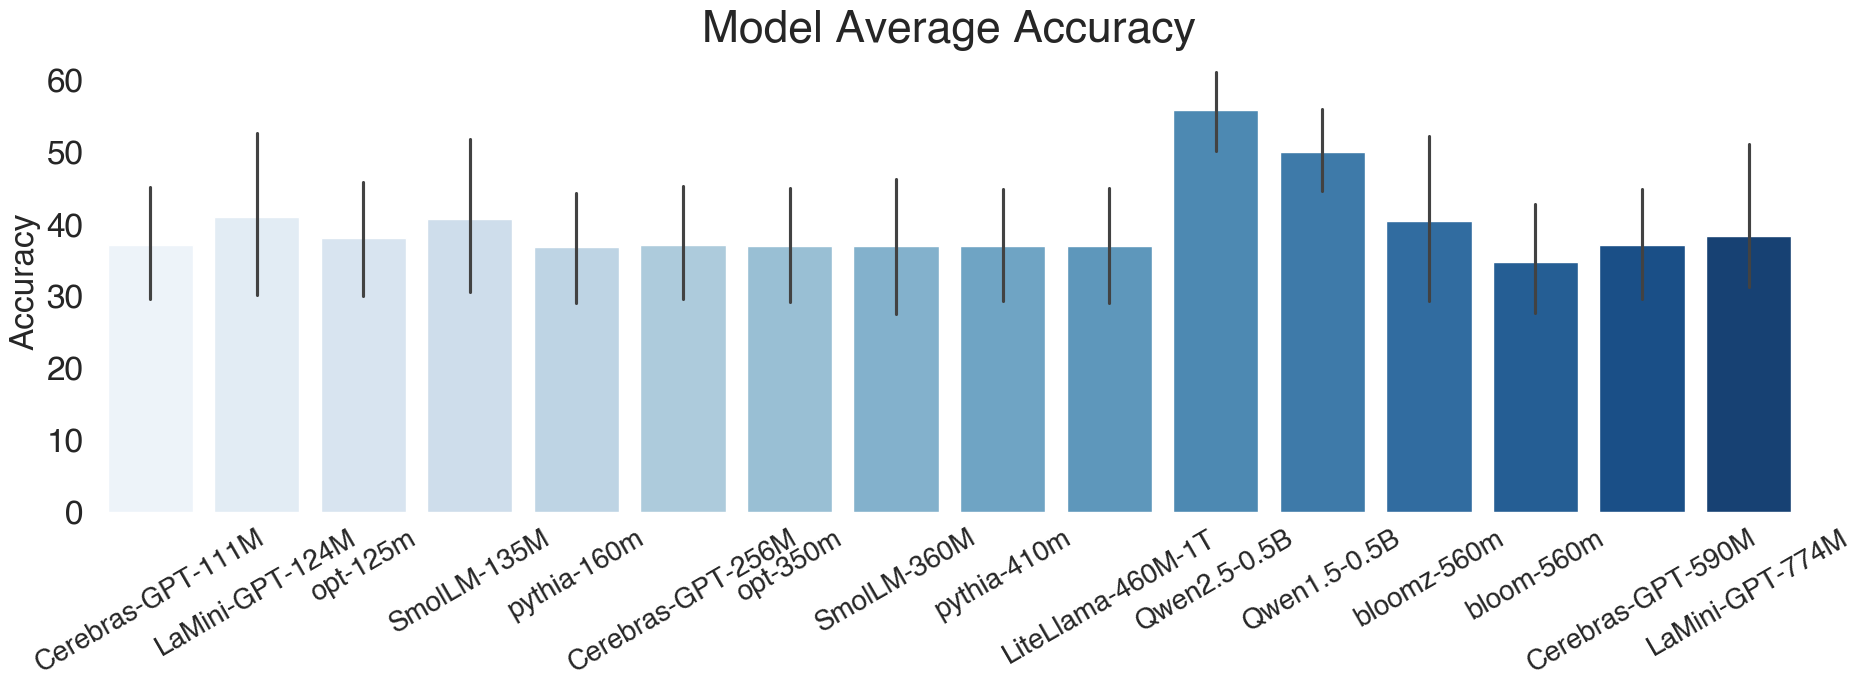

In [57]:
sns.set(style="white", font='Helvetica')
plt.figure(figsize=(22, 6))
sns.barplot(data=data, x='Model', y='Accuracy',  palette = 'Blues')
sns.despine(left=True, bottom=True)

plt.title('Model Average Accuracy', fontsize=32, fontweight='bold')
plt.xlabel(None)
plt.ylabel('Accuracy', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=24)

plt.show()

/var/folders/bj/tl0_3rjs2r309b_7b62d64yh0000gn/T/ipykernel_20887/657808026.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Model', y='Average Inference Time (ms)',  palette = 'Oranges')


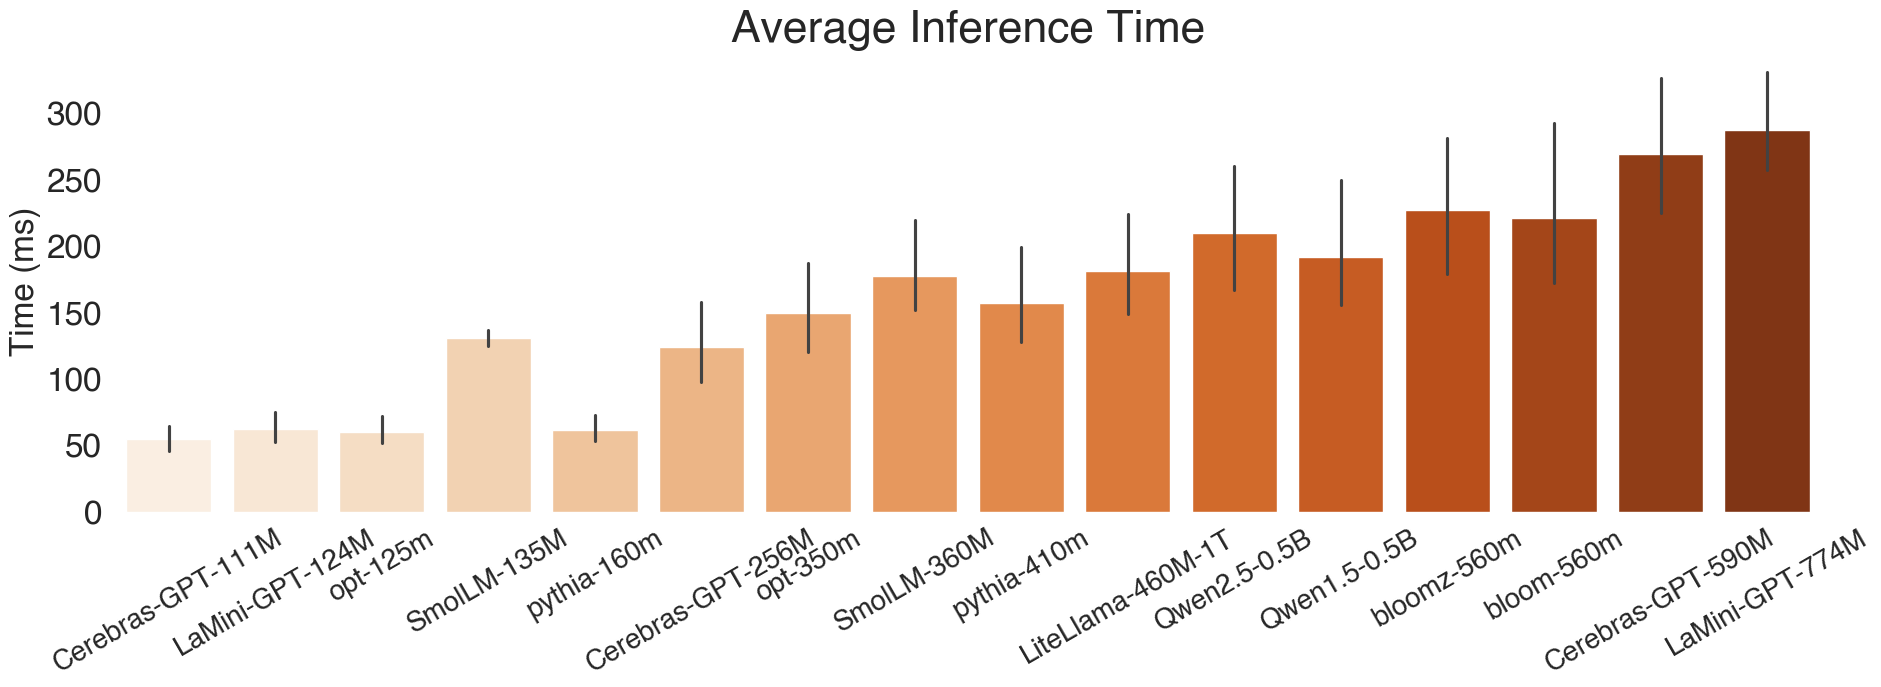

In [58]:
sns.set(style="white", font='Helvetica')
plt.figure(figsize=(22, 6))
sns.barplot(data=data, x='Model', y='Average Inference Time (ms)',  palette = 'Oranges')
sns.despine(left=True, bottom=True)

plt.title('Average Inference Time', fontsize=32, fontweight='bold')
plt.xlabel(None)
plt.ylabel('Time (ms)', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=24)

plt.show()

/var/folders/bj/tl0_3rjs2r309b_7b62d64yh0000gn/T/ipykernel_20887/4169702109.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Model', y='GPU Memory Usage (GB)',  palette = 'Greens')


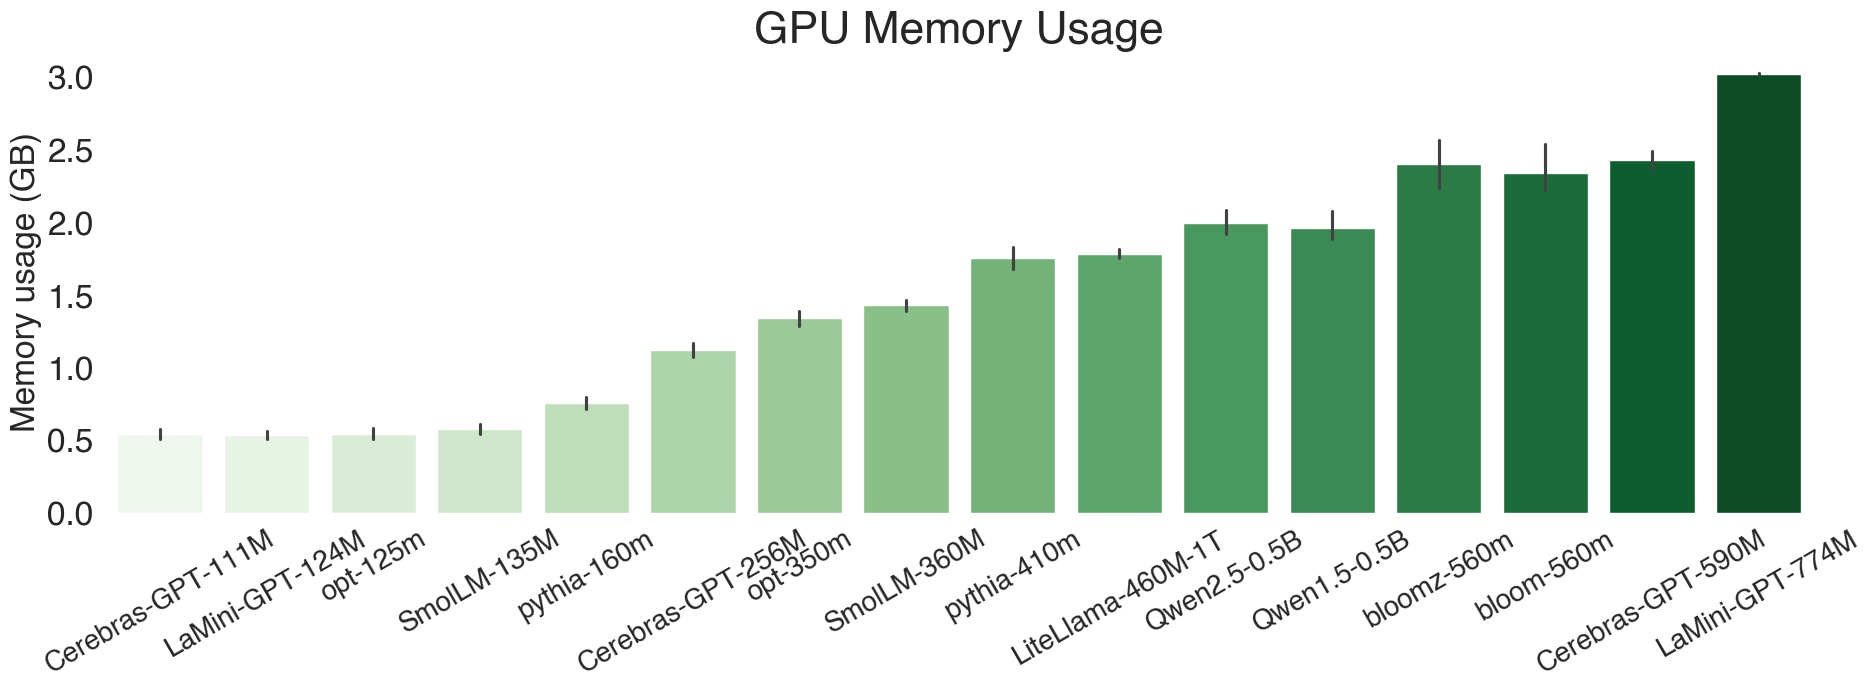

In [59]:
sns.set(style="white", font='Helvetica')
plt.figure(figsize=(22, 6))
sns.barplot(data=data, x='Model', y='GPU Memory Usage (GB)',  palette = 'Greens')
sns.despine(left=True, bottom=True)

plt.title('GPU Memory Usage', fontsize=32, fontweight='bold')
plt.xlabel(None)
plt.ylabel('Memory usage (GB)', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=24)

plt.show()